In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_squared_error
import lightgbm as lgb

import gc
import time

from ipywidgets import interact

In [31]:
df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv')
df_items = pd.read_csv('items.csv', index_col='item_id')
df_categories = pd.read_csv('categories.csv', index_col='category_id')
df_shops = pd.read_csv('shops.csv', index_col='shop_id')
df_sub   = pd.read_csv("sample_submission.csv", index_col="ID")

In [32]:
df_train.describe()
# df_categories.describe()
# df_shops.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [33]:
df_train['item_cnt_day'].sort_values(ascending=False)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
            ...  
59156        -6.0
940092       -6.0
2048519      -9.0
1835454     -16.0
1057907     -22.0
Name: item_cnt_day, Length: 2935849, dtype: float64

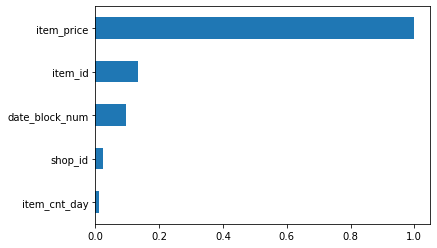

In [34]:
df_train.corr()["item_price"].abs().sort_values().plot.barh();

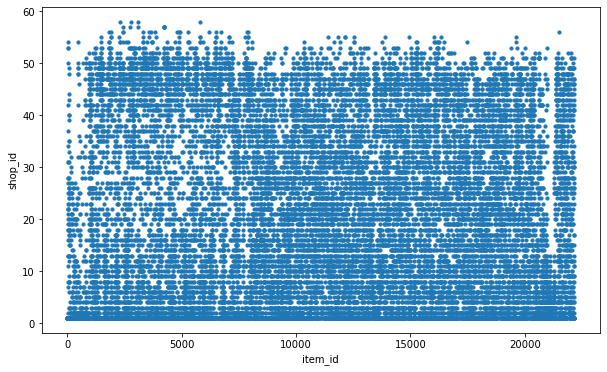

In [35]:
df_train.groupby("item_id").agg({"shop_id": "nunique"}).reset_index().plot.scatter("item_id", "shop_id", figsize=(10, 6), s=10);

### October 2015 sales

In [36]:
october_sales = df_train.loc[df_train['date_block_num']==33]
october_sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882335,23.10.2015,33,45,13315,649.0,1.0
2882336,05.10.2015,33,45,13880,229.0,1.0
2882337,02.10.2015,33,45,13881,659.0,1.0
2882338,12.10.2015,33,45,13881,659.0,1.0
2882339,04.10.2015,33,45,13923,169.0,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


In [37]:
october_sales = df_train[df_train.date_block_num==33]

In [38]:
df_train.drop(df_train.loc[df_train['date_block_num'] != 33 ].index, inplace=True)

df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882335,23.10.2015,33,45,13315,649.0,1.0
2882336,05.10.2015,33,45,13880,229.0,1.0
2882337,02.10.2015,33,45,13881,659.0,1.0
2882338,12.10.2015,33,45,13881,659.0,1.0
2882339,04.10.2015,33,45,13923,169.0,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


In [39]:
df_train.groupby(['date_block_num']).agg(['mean'])

,shop_id,item_id,item_price,item_cnt_day
,mean,mean,mean,mean
date_block_num,,,,
33,31.580969,10799.986583,1224.574825,1.327802


In [40]:
df_train_1 = df_train[df_train.item_cnt_day < 0]

In [41]:
full = df_train.shape[0]
ref = df_train_1.shape[0]
percentage_refunds = round(ref / full, 5)
print("% of refunds:", percentage_refunds * 100, '%')

% of refunds: 0.23900000000000002 %


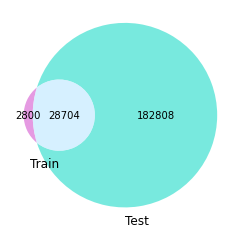

In [63]:
venn2([set((df_train.shop_id.astype(str) + df_train.item_id.astype(str)).unique()),
       set((df_test.shop_id.astype(str)  + df_test.item_id.astype(str)).unique())],
      set_labels = ('Train', 'Test'), set_colors=('orchid', 'turquoise'), alpha = 0.7)
plt.show()

## October X November

In [68]:
sep_2015 = df_train[df_train.date_block_num==32]
oct_2015 = df_train[df_train.date_block_num==33]

oct15_item_shop = oct_2015.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()

oct15_item_shop

,shop_id,item_id,item_cnt_day
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0
...,...,...,...
31526,59,22087,6.0
31527,59,22088,2.0
31528,59,22091,1.0
31529,59,22100,1.0


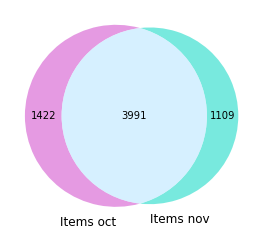

In [70]:
venn2([set(oct_2015.item_id.unique()),
       set(df_test.item_id.unique())],
      set_labels = ('Items oct', 'Items nov'), set_colors=('orchid', 'turquoise'), alpha = 0.7)
plt.show()


/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


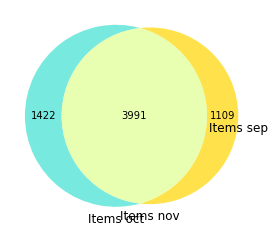

In [71]:
venn3([set(sep_2015.item_id.unique()),
       set(oct_2015.item_id.unique()),
       set(df_test.item_id.unique())],
      set_labels = ('Items sep', 'Items oct', 'Items nov'), set_colors=('orchid', 'turquoise', 'gold'), alpha = 0.7)
plt.show()


In [72]:
october_sales.shop_id.nunique()

44

In [73]:
october_sales.item_id.nunique()

5413

In [74]:
october_sales.groupby(["shop_id", "item_id"])[["item_cnt_day"]].agg(["min", "max", "mean", "count", "sum"])

item_cnt_day                     
                         min  max mean count  sum
shop_id item_id                                  
2       31               1.0  1.0  1.0     1  1.0
        486              1.0  1.0  1.0     3  3.0
        787              1.0  1.0  1.0     1  1.0
        794              1.0  1.0  1.0     1  1.0
        968              1.0  1.0  1.0     1  1.0
...                      ...  ...  ...   ...  ...
59      22087            1.0  3.0  2.0     3  6.0
        22088            1.0  1.0  1.0     2  2.0
        22091            1.0  1.0  1.0     1  1.0
        22100            1.0  1.0  1.0     1  1.0
        22102            1.0  1.0  1.0     1  1.0

[31531 rows x 5 columns]

In [50]:
october_sales_agg = october_sales.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()

In [51]:
df_test


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [52]:
df_sub.head()

,item_cnt_month
ID,
0,0.5
1,0.5
2,0.5
3,0.5
4,0.5


In [53]:
results = pd.merge(left = df_test,         # Left table for the join
                   right = october_sales_agg, # Right table for the join
                   on=["shop_id", "item_id"], # Common keys
                   how='left')          # Type of join

results.head()

,ID,shop_id,item_id,item_cnt_day
0,0,5,5037,NaN
1,1,5,5320,NaN
2,2,5,5233,1.0
3,3,5,5232,NaN
4,4,5,5268,NaN


In [54]:
print("% of missings:", results.item_cnt_day.isna().sum() / len(results) * 100)

% of missings: 86.61064425770309


In [55]:
# Fill missings with zeros

results.item_cnt_day = results.item_cnt_day.fillna(0)
results.head()

,ID,shop_id,item_id,item_cnt_day
0,0,5,5037,0.0
1,1,5,5320,0.0
2,2,5,5233,1.0
3,3,5,5232,0.0
4,4,5,5268,0.0


In [56]:
# clipping (limit) mins and max values
results.item_cnt_day = results.item_cnt_day.clip(lower=0, upper=20)
results.head()

,ID,shop_id,item_id,item_cnt_day
0,0,5,5037,0.0
1,1,5,5320,0.0
2,2,5,5233,1.0
3,3,5,5232,0.0
4,4,5,5268,0.0


In [57]:
df_sub["item_cnt_month"] = results["item_cnt_day"]
df_sub.head()

,item_cnt_month
ID,
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [58]:
df_sub.to_csv("oct2015.csv")

In [59]:
!head oct2015.csv

ID,item_cnt_month
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
5,1.0
6,2.0
7,0.0
8,0.0
